In [1]:
import os
import h5py
import numpy as np
from pyproj import Proj
from geopy.distance import geodesic
from scipy.ndimage import label

# === CONFIGURATION ===
raw_h5_dir = r"C:/Users/Rupam Manna/Desktop/INSAT_TCC_Project/raw_h5"
output_dir = r"C:/Users/Rupam Manna/Desktop/INSAT_TCC_Project/training_data"

bt_threshold = 235  # Kelvin
min_area_km2 = 34800
min_deg_span = 1.0
indep_radius_km = 1200

# === PROJECTION ===
proj_merc = Proj(proj='merc', lon_0=75.0, lat_ts=0.0, a=6378137, b=6356752.3142)

# === LOOP OVER FILES ===
for fname in os.listdir(raw_h5_dir):
    if not fname.endswith(".h5"):
        continue

    file_path = os.path.join(raw_h5_dir, fname)
    print(f"Processing {fname}")

    # === READ .h5 FILE ===
    with h5py.File(file_path, 'r') as f:
        bt = f['/TIR1_BT'][0, :, :]
        x = f['/X'][:]
        y = f['/Y'][:]

    # === CONVERT TO LAT/LON ===
    X, Y = np.meshgrid(x, y)
    lon, lat = proj_merc(X, Y, inverse=True)

    # === BASIC MASK ===
    tcc_mask = bt < bt_threshold
    labeled_array, _ = label(tcc_mask)

    # === GEOMETRIC FILTERS ===
    dx_m = np.mean(np.abs(np.diff(x)))
    dy_m = np.mean(np.abs(np.diff(y)))
    pixel_area_km2 = (dx_m / 1000) * (dy_m / 1000)

    valid_clusters = []
    for cluster_id in np.unique(labeled_array)[1:]:
        mask_cluster = labeled_array == cluster_id
        area_km2 = np.sum(mask_cluster) * pixel_area_km2

        if area_km2 < min_area_km2:
            continue

        lat_vals = lat[mask_cluster]
        lon_vals = lon[mask_cluster]
        if (lat_vals.max() - lat_vals.min() < min_deg_span) and (lon_vals.max() - lon_vals.min() < min_deg_span):
            continue

        valid_clusters.append({
            'id': cluster_id,
            'mask': mask_cluster,
            'lat_mean': np.mean(lat_vals),
            'lon_mean': np.mean(lon_vals),
        })

    # === INDEPENDENCE FILTER ===
    final_clusters = []
    remaining = valid_clusters.copy()
    while remaining:
        parent = max(remaining, key=lambda c: np.sum(c['mask']))
        final_clusters.append(parent)
        remaining = [c for c in remaining if geodesic(
            (parent['lat_mean'], parent['lon_mean']),
            (c['lat_mean'], c['lon_mean'])
        ).km > indep_radius_km]

    # === CREATE FINAL MASK ===
    final_mask = np.zeros_like(bt, dtype=np.uint8)
    for cluster in final_clusters:
        final_mask[cluster['mask']] = 1

    # === SAVE BT AND MASK ===
    base_name = os.path.splitext(fname)[0]
    np.save(os.path.join(output_dir, f"{base_name}_bt.npy"), bt)
    np.save(os.path.join(output_dir, f"{base_name}_mask.npy"), final_mask)

print("✅ Classical BT/mask pairs saved to 'training_data/'")

Processing 3DIMG_18JUN2024_0000_L1C_SGP_V01R00_B3 (2).h5
Processing 3DIMG_18JUN2024_0030_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0100_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0130_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0200_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0230_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0300_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0330_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0400_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0530_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0600_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0630_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0700_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0730_L1C_SGP_V01R00_B3.h5
Processing 3DIMG_18JUN2024_0800_L1C_SGP_V01R00_B3.h5
✅ Classical BT/mask pairs saved to 'training_data/'


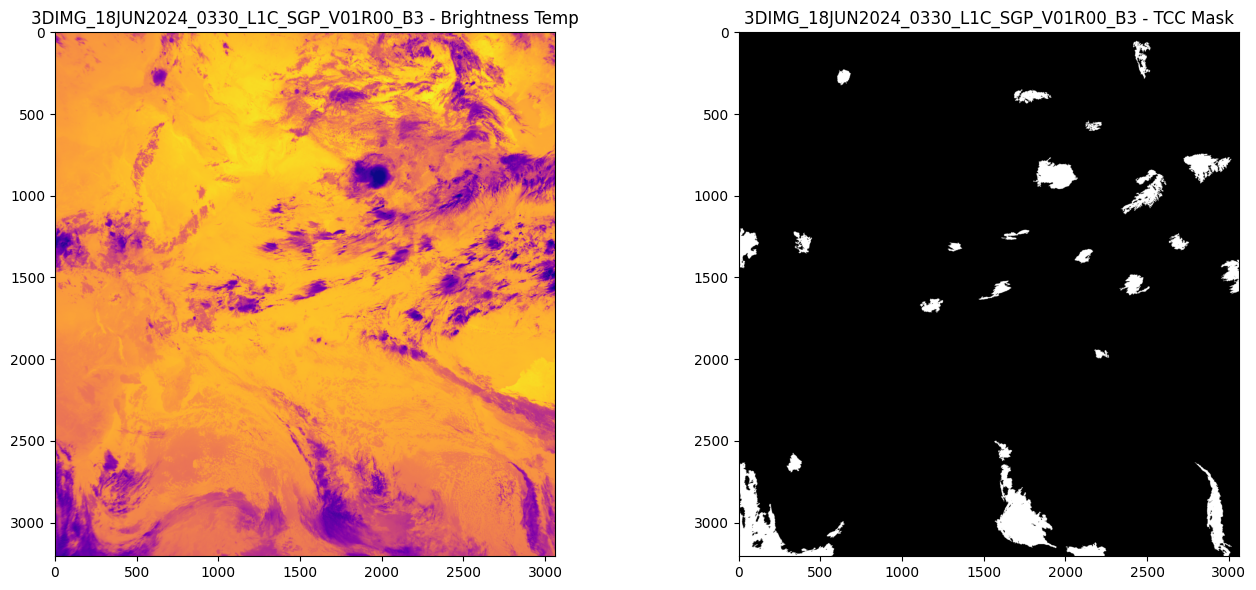

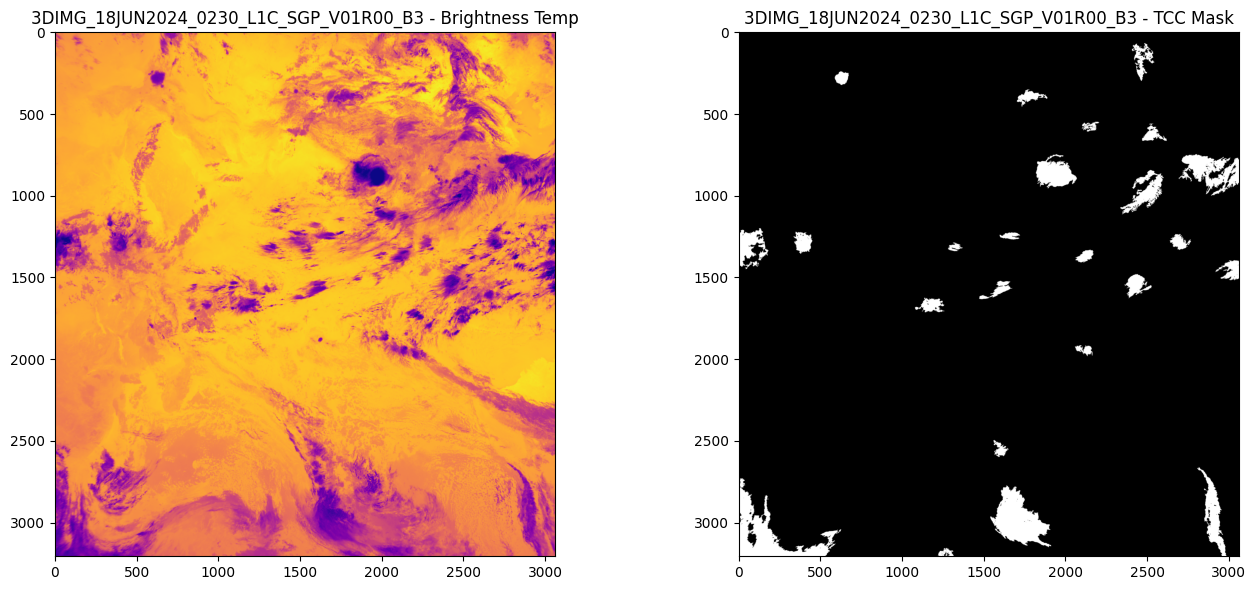

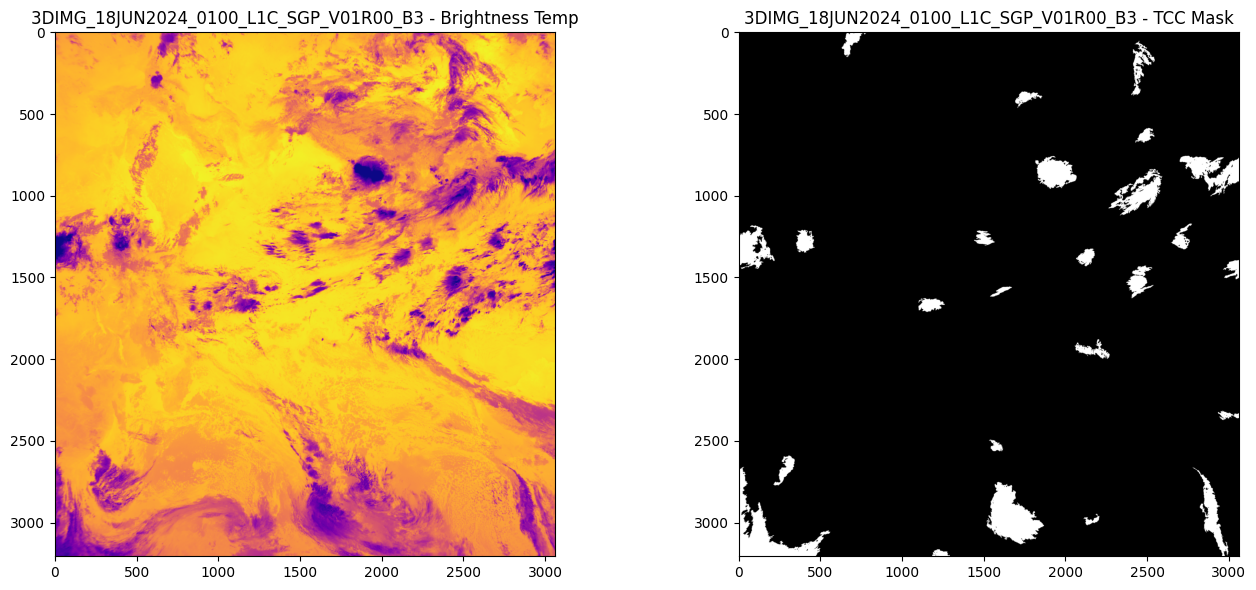

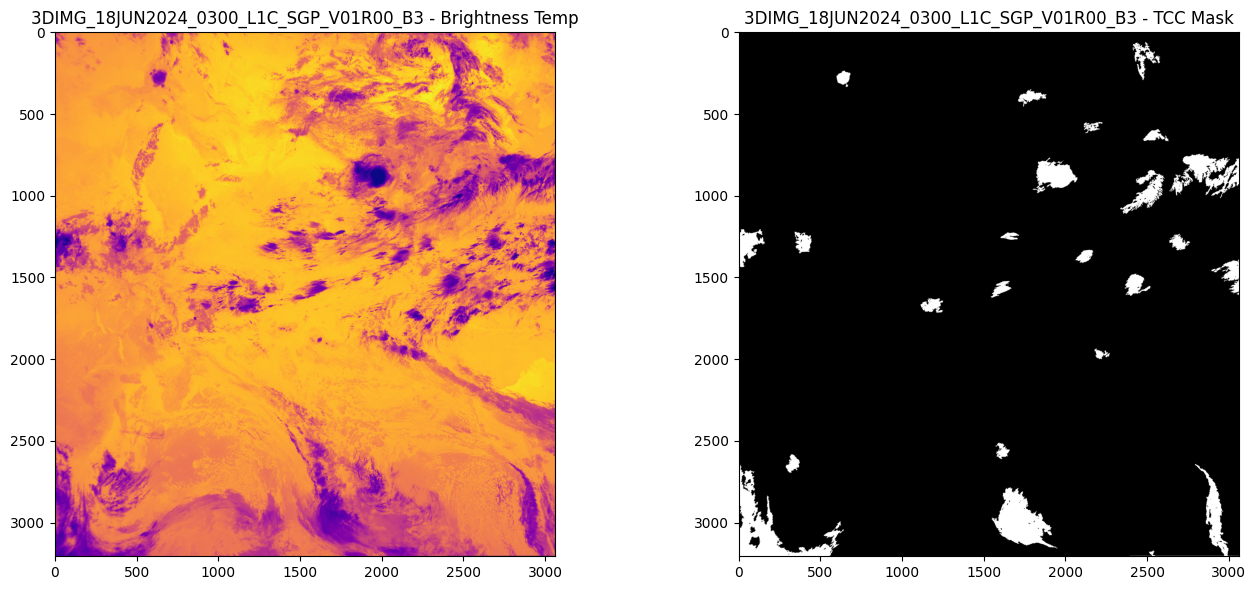

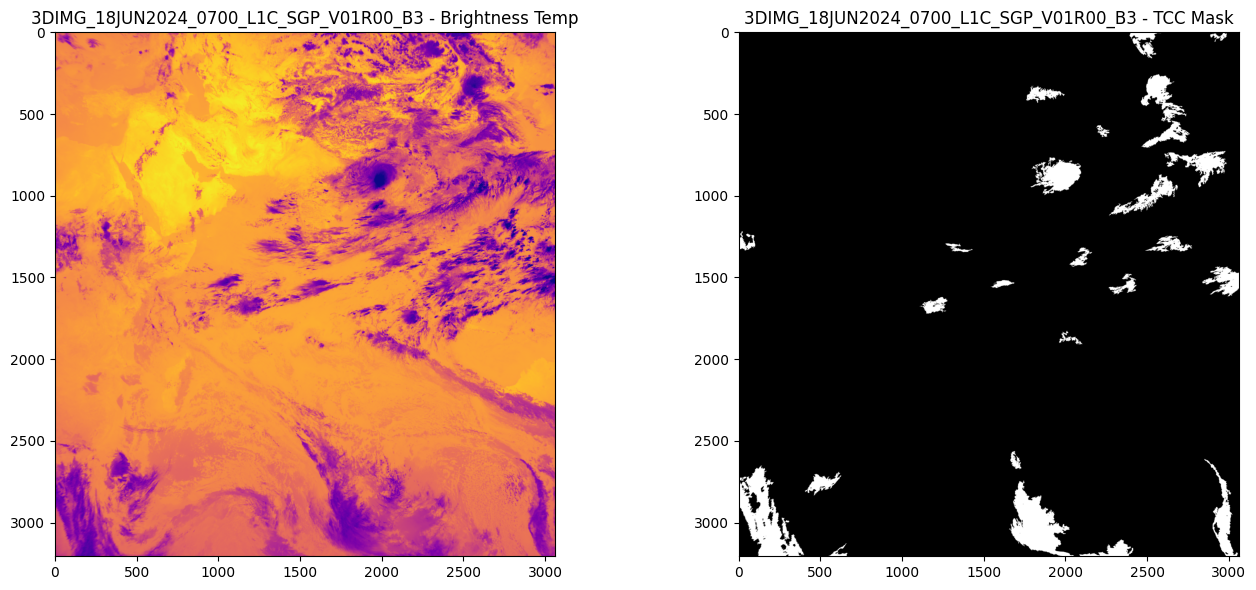

In [3]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the folder where your .npy files are saved
training_data_dir = r"C:/Users/Rupam Manna/Desktop/INSAT_TCC_Project/training_data"

# List of all bt files (assumes paired _bt.npy and _mask.npy)
all_bt_files = [f for f in os.listdir(training_data_dir) if f.endswith("_bt.npy")]
sample_files = random.sample(all_bt_files, 5)

for bt_file in sample_files:
    base = bt_file.replace("_bt.npy", "")
    bt = np.load(os.path.join(training_data_dir, f"{base}_bt.npy"))
    mask = np.load(os.path.join(training_data_dir, f"{base}_mask.npy"))

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].imshow(bt, cmap="plasma")
    axs[0].set_title(f"{base} - Brightness Temp")
    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title(f"{base} - TCC Mask")
    plt.tight_layout()
    plt.show()

In [6]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

# === PATH CONFIGURATION ===
project_root = r'C:/Users/Rupam Manna/Desktop/INSAT_TCC_Project'
training_data_dir = os.path.join(project_root, 'training_data')
model_save_path = os.path.join(project_root, 'models', 'tcc_unet_model.keras')


# === DATA GENERATOR ===
class TCCDataGenerator(Sequence):
    def __init__(self, data_dir, batch_size=4, input_size=(256, 256), shuffle=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle

        all_files = os.listdir(data_dir)
        self.base_names = sorted([
            fname.replace('_bt.npy', '') for fname in all_files if fname.endswith('_bt.npy')
        ])

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.base_names) / self.batch_size))

    def __getitem__(self, index):
        batch_base_names = self.base_names[index * self.batch_size:(index + 1) * self.batch_size]

        batch_imgs, batch_masks = [], []

        for base in batch_base_names:
            img = np.load(os.path.join(self.data_dir, base + '_bt.npy'))
            mask = np.load(os.path.join(self.data_dir, base + '_mask.npy'))

            # Resize if needed
            img = np.resize(img, self.input_size)
            mask = np.resize(mask, self.input_size)

            # Normalize BT image to [0, 1]
            img = (img - img.min()) / (img.max() - img.min())

            batch_imgs.append(img[..., np.newaxis])   # shape: (H, W, 1)
            batch_masks.append(mask[..., np.newaxis]) # shape: (H, W, 1)

        return np.array(batch_imgs), np.array(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.base_names)


# === U-NET MODEL ===
def build_unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # Bottleneck
    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(32, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(16, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    return Model(inputs, outputs)


# === COMPILE & TRAIN ===
model = build_unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

train_gen = TCCDataGenerator(training_data_dir, batch_size=4)

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

# === SAVE MODEL ===
model.save(model_save_path)
print(f"✅ Model saved at: {model_save_path}")

C:\Users\Rupam Manna\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.9769 - loss: 0.6609
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.9807 - loss: 0.6510
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.9838 - loss: 0.6393
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.9771 - loss: 0.6263
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.9806 - loss: 0.6078
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.9819 - loss: 0.5840
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.9790 - loss: 0.5455
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.9826 - loss: 0.4791
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.9851 - loss: 0.3592
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.9851 - loss: 0.1864
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.9804 - loss: 0.1145
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.9819 - lo

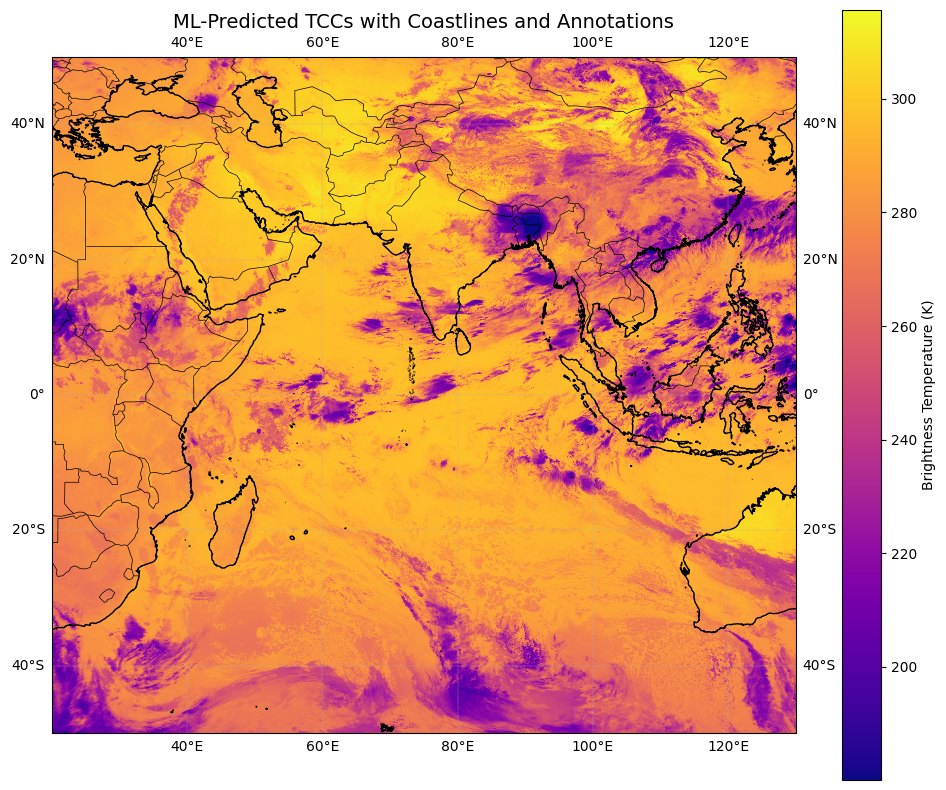

In [8]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tensorflow.keras.models import load_model
from scipy.ndimage import label
from geopy.distance import geodesic
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === CONFIG ===
project_root = r'C:/Users/Rupam Manna/Desktop/INSAT_TCC_Project'
model_path = os.path.join(project_root, 'models', 'tcc_unet_model.keras')
h5_file = os.path.join(project_root, 'raw_h5', '3DIMG_18JUN2024_0330_L1C_SGP_V01R00_B3.h5')  # Change file name
patch_size = 256
indep_radius_km = 1200

# === LOAD MODEL ===
model = load_model(model_path)

# === LOAD H5 FILE ===
with h5py.File(h5_file, 'r') as f:
    bt = f['/TIR1_BT'][0, :, :]
    x = f['/X'][:]
    y = f['/Y'][:]

# === NORMALIZE BT & PAD ===
bt_norm = (bt - bt.min()) / (bt.max() - bt.min())
pad_y = (patch_size - bt.shape[0] % patch_size) % patch_size
pad_x = (patch_size - bt.shape[1] % patch_size) % patch_size
bt_padded = np.pad(bt_norm, ((0, pad_y), (0, pad_x)), mode='reflect')

# === PREDICT PATCHES ===
predicted_mask = np.zeros_like(bt_padded)
for y_ in range(0, bt_padded.shape[0], patch_size):
    for x_ in range(0, bt_padded.shape[1], patch_size):
        patch = bt_padded[y_:y_+patch_size, x_:x_+patch_size]
        patch_input = patch[np.newaxis, ..., np.newaxis]
        pred_patch = model.predict(patch_input, verbose=0)[0, ..., 0]
        predicted_mask[y_:y_+patch_size, x_:x_+patch_size] = pred_patch

# === CLEAN MASK ===
predicted_mask = predicted_mask[:bt.shape[0], :bt.shape[1]]
binary_mask = (predicted_mask > 0.5).astype(np.uint8)
labeled_array, _ = label(binary_mask)

# === GEOPROJECTION ===
proj_merc = Proj(proj='merc', lon_0=75.0, lat_ts=0.0, a=6378137, b=6356752.3142)
X, Y = np.meshgrid(x, y)
lon, lat = proj_merc(X, Y, inverse=True)

# === IDENTIFY CLUSTERS ===
cluster_data = []
cluster_ids = np.unique(labeled_array)[1:]  # skip 0

for cid in cluster_ids:
    mask = labeled_array == cid
    y_idx, x_idx = np.where(mask)
    lat_vals = lat[mask]
    lon_vals = lon[mask]
    bt_vals = bt[mask]

    coldest_idx = np.argmin(bt_vals)
    cy, cx = y_idx[coldest_idx], x_idx[coldest_idx]
    
    cluster_data.append({
        'id': cid,
        'lat': lat[cy, cx],
        'lon': lon[cy, cx],
        'mask': mask,
        'pixel_count': np.sum(mask)
    })

# === INDEPENDENT FILTERING ===
final_clusters = []
remaining = cluster_data.copy()

while remaining:
    parent = max(remaining, key=lambda c: c['pixel_count'])
    final_clusters.append(parent)
    remaining = [
        c for c in remaining
        if geodesic((parent['lat'], parent['lon']), (c['lat'], c['lon'])).km > indep_radius_km
    ]

# === PLOT IN NOTEBOOK ===
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("ML-Predicted TCCs with Coastlines and Annotations", fontsize=14)

# BT background
bt_img = ax.pcolormesh(lon, lat, bt, cmap='plasma', shading='auto', transform=ccrs.PlateCarree())
plt.colorbar(bt_img, ax=ax, orientation='vertical', label='Brightness Temperature (K)')

# Coastlines and features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# Overlay and annotate
for idx, cluster in enumerate(final_clusters, start=1):
    mask = cluster['mask']
    ax.scatter(lon[mask], lat[mask], s=1.5, color='cyan', transform=ccrs.PlateCarree())
    ax.text(cluster['lon'], cluster['lat'], str(idx), fontsize=9, color='black', weight='bold',
            ha='center', va='center', transform=ccrs.PlateCarree(),
            bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

ax.set_extent([np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.3, linestyle='--')

plt.show()

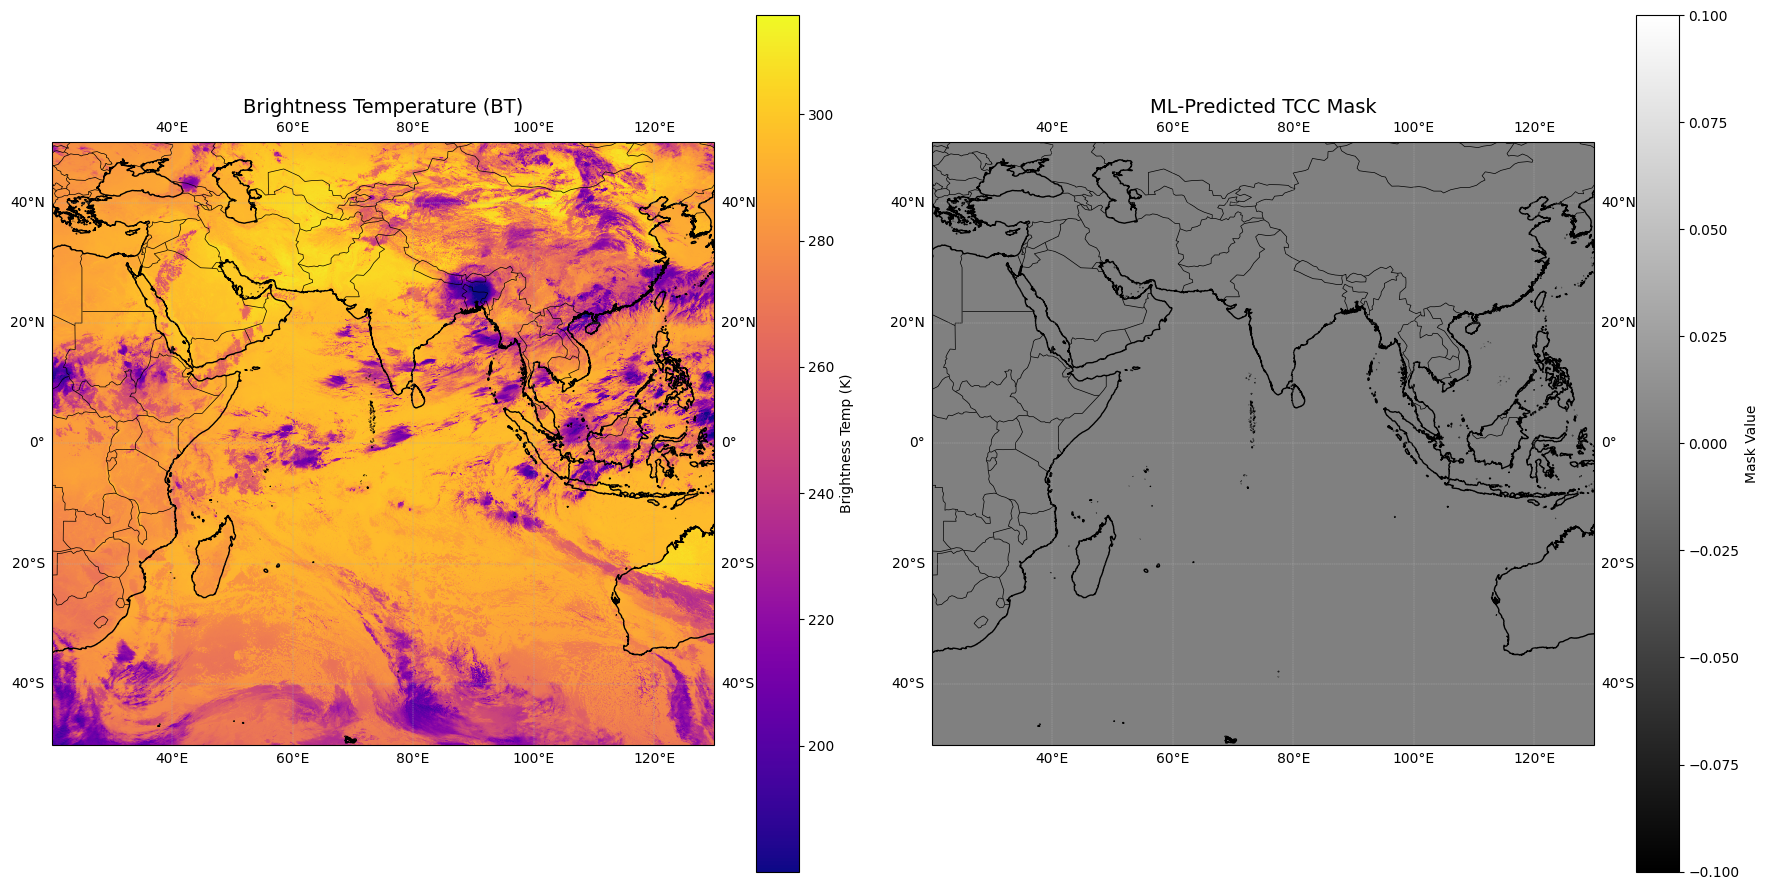

In [10]:
# === NEW: SIDE-BY-SIDE VISUALIZATION ===
fig, axes = plt.subplots(1, 2, figsize=(18, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# --- LEFT: Brightness Temperature ---
axes[0].set_title("Brightness Temperature (BT)", fontsize=14)
bt_plot = axes[0].pcolormesh(lon, lat, bt, cmap='plasma', shading='auto', transform=ccrs.PlateCarree())
plt.colorbar(bt_plot, ax=axes[0], orientation='vertical', label='Brightness Temp (K)')
axes[0].coastlines(resolution='10m')
axes[0].add_feature(cfeature.BORDERS, linewidth=0.5)
axes[0].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
axes[0].add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# --- RIGHT: Predicted Binary Mask ---
axes[1].set_title("ML-Predicted TCC Mask", fontsize=14)
# Convert binary mask to 0/255 for visualization
binary_img = binary_mask * 255
mask_plot = axes[1].pcolormesh(lon, lat, binary_img, cmap='gray', shading='auto', transform=ccrs.PlateCarree())
plt.colorbar(mask_plot, ax=axes[1], orientation='vertical', label='Mask Value')
axes[1].coastlines(resolution='10m')
axes[1].add_feature(cfeature.BORDERS, linewidth=0.5)
axes[1].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
axes[1].add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# --- Annotate Cluster IDs on mask image ---
for idx, cluster in enumerate(final_clusters, start=1):
    axes[1].text(cluster['lon'], cluster['lat'], str(idx), fontsize=9, color='red', weight='bold',
                 ha='center', va='center', transform=ccrs.PlateCarree(),
                 bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

# Same geographic extent
for ax in axes:
    ax.set_extent([np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, linewidth=0.3, linestyle='--')

plt.tight_layout()
plt.show()

✅ Debug Info:
→ Prediction shape: (3207, 3062)
→ Max value in predicted mask: 0.48268944
→ Min value in predicted mask: 0.0030598752
→ Mean predicted value: 0.03222844
→ Binary mask sum (threshold=0.1): 492100


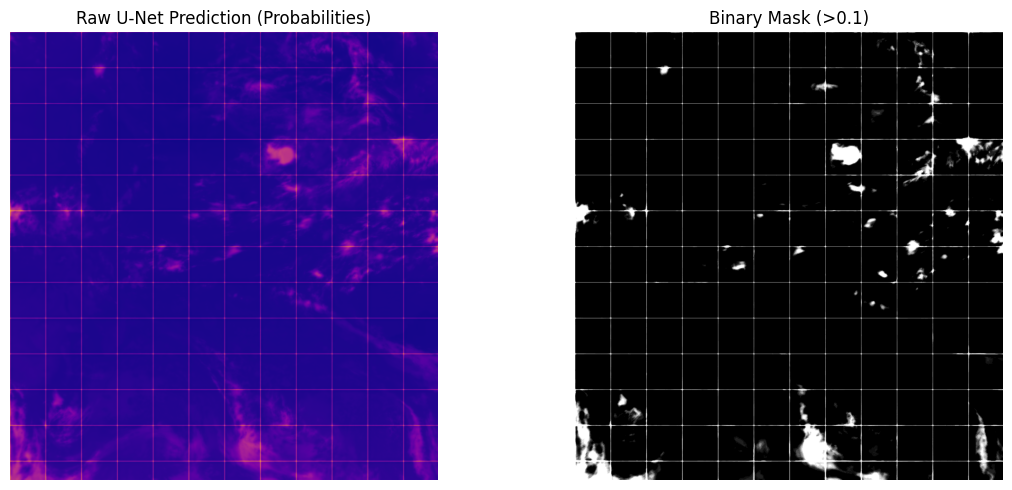

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Check stats
print("✅ Debug Info:")
print("→ Prediction shape:", predicted_mask.shape)
print("→ Max value in predicted mask:", predicted_mask.max())
print("→ Min value in predicted mask:", predicted_mask.min())
print("→ Mean predicted value:", predicted_mask.mean())

# Thresholding (try different thresholds)
threshold = 0.1
binary_mask = (predicted_mask > threshold).astype(np.uint8)

print(f"→ Binary mask sum (threshold={threshold}):", binary_mask.sum())

# Plot raw prediction vs thresholded mask
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw prediction (probability map)
axes[0].imshow(predicted_mask.squeeze(), cmap='plasma')
axes[0].set_title("Raw U-Net Prediction (Probabilities)")
axes[0].axis('off')

# Thresholded mask
axes[1].imshow(binary_mask.squeeze(), cmap='gray')
axes[1].set_title(f"Binary Mask (>{threshold})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

✅ Saved predicted mask to: C:/Users/Rupam Manna/Desktop/INSAT_TCC_Project\results\predictions\3DIMG_18JUN2024_0330_L1C_SGP_V01R00_B3_ml_pred.npy
✅ Debug Info:
→ Prediction shape: (3207, 3062)
→ Max value in predicted mask: 0.48268944
→ Min value in predicted mask: 0.0030598752
→ Mean predicted value: 0.03222844
→ Binary mask sum (threshold=0.1): 492100


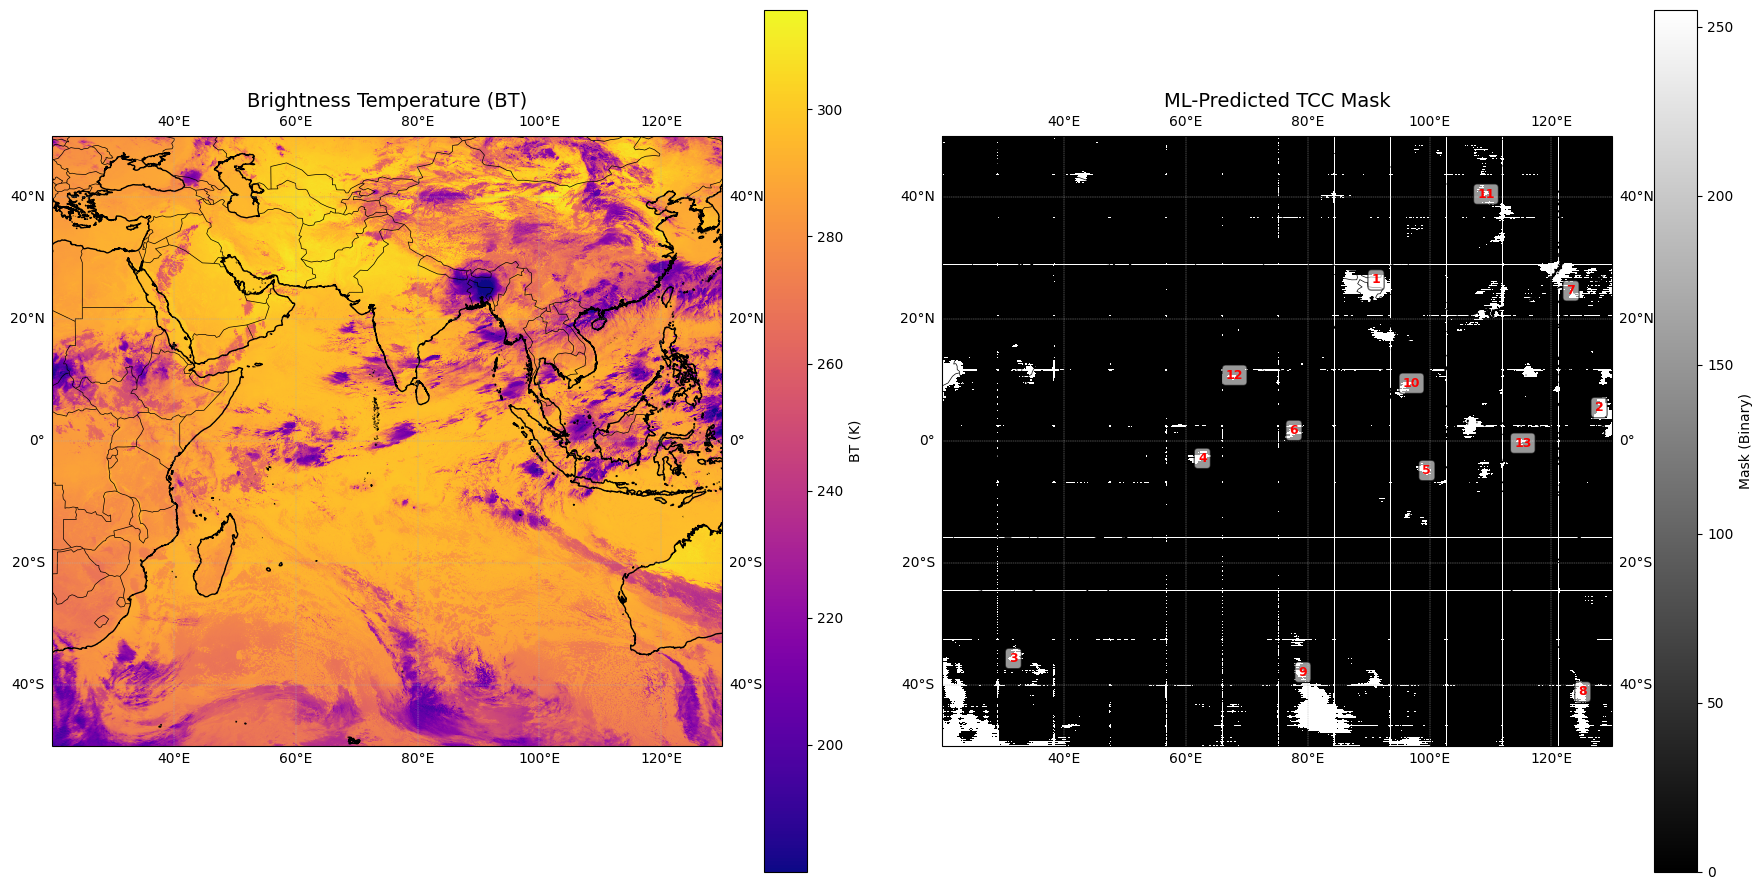

In [18]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tensorflow.keras.models import load_model
from scipy.ndimage import label
from geopy.distance import geodesic
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === CONFIG ===
project_root = r'C:/Users/Rupam Manna/Desktop/INSAT_TCC_Project'
model_path = os.path.join(project_root, 'models', 'tcc_unet_model.keras')
h5_file = os.path.join(project_root, 'raw_h5', '3DIMG_18JUN2024_0330_L1C_SGP_V01R00_B3.h5')
patch_size = 256
indep_radius_km = 1200
threshold = 0.1  # Threshold for ML prediction mask
min_pixels = 500  # Filter out small blobs

# === LOAD MODEL ===
model = load_model(model_path)

# === LOAD H5 FILE ===
with h5py.File(h5_file, 'r') as f:
    bt = f['/TIR1_BT'][0, :, :]
    x = f['/X'][:]
    y = f['/Y'][:]

# === NORMALIZE BT ===
bt_norm = (bt - bt.min()) / (bt.max() - bt.min())

# === PAD BT TO PATCH SIZE ===
pad_y = (patch_size - bt.shape[0] % patch_size) % patch_size
pad_x = (patch_size - bt.shape[1] % patch_size) % patch_size
bt_padded = np.pad(bt_norm, ((0, pad_y), (0, pad_x)), mode='reflect')

# === RUN PATCH-WISE INFERENCE ===
predicted_mask = np.zeros_like(bt_padded)
for y_ in range(0, bt_padded.shape[0], patch_size):
    for x_ in range(0, bt_padded.shape[1], patch_size):
        patch = bt_padded[y_:y_+patch_size, x_:x_+patch_size]
        patch_input = patch[np.newaxis, ..., np.newaxis]
        pred_patch = model.predict(patch_input, verbose=0)[0, ..., 0]
        predicted_mask[y_:y_+patch_size, x_:x_+patch_size] = pred_patch

# === REMOVE PADDING ===
predicted_mask = predicted_mask[:bt.shape[0], :bt.shape[1]]

# === SAVE PREDICTED MASK ===
base_filename = os.path.splitext(os.path.basename(h5_file))[0]
save_mask_path = os.path.join(project_root, 'results', 'predictions', f'{base_filename}_ml_pred.npy')
os.makedirs(os.path.dirname(save_mask_path), exist_ok=True)
np.save(save_mask_path, predicted_mask)
print("✅ Saved predicted mask to:", save_mask_path)

# === DEBUG INFO ===
print("✅ Debug Info:")
print("→ Prediction shape:", predicted_mask.shape)
print("→ Max value in predicted mask:", predicted_mask.max())
print("→ Min value in predicted mask:", predicted_mask.min())
print("→ Mean predicted value:", predicted_mask.mean())

# === BINARY MASK & LABELING ===
binary_mask = (predicted_mask > threshold).astype(np.uint8)
print(f"→ Binary mask sum (threshold={threshold}):", binary_mask.sum())

labeled_array, _ = label(binary_mask)
cluster_ids = np.unique(labeled_array)[1:]

# === GEOPROJECTION ===
proj_merc = Proj(proj='merc', lon_0=75.0, lat_ts=0.0, a=6378137, b=6356752.3142)
X, Y = np.meshgrid(x, y)
lon, lat = proj_merc(X, Y, inverse=True)

# === PROCESS CLUSTERS ===
cluster_data = []
for cid in cluster_ids:
    indices = np.argwhere(labeled_array == cid)
    if len(indices) < min_pixels:
        continue

    y_idx, x_idx = indices[:, 0], indices[:, 1]
    bt_vals = bt[y_idx, x_idx]
    coldest_idx = np.argmin(bt_vals)
    cy, cx = y_idx[coldest_idx], x_idx[coldest_idx]

    mask = np.zeros_like(binary_mask, dtype=bool)
    mask[y_idx, x_idx] = True

    cluster_data.append({
        'id': cid,
        'lat': lat[cy, cx],
        'lon': lon[cy, cx],
        'mask': mask,
        'pixel_count': len(indices)
    })

# === INDEPENDENT CLUSTER FILTERING ===
final_clusters = []
remaining = cluster_data.copy()

while remaining:
    parent = max(remaining, key=lambda c: c['pixel_count'])
    final_clusters.append(parent)
    remaining = [
        c for c in remaining
        if geodesic((parent['lat'], parent['lon']), (c['lat'], c['lon'])).km > indep_radius_km
    ]

# === PLOT: SIDE-BY-SIDE VISUALIZATION ===
fig, axes = plt.subplots(1, 2, figsize=(18, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# --- LEFT: BT ---
axes[0].set_title("Brightness Temperature (BT)", fontsize=14)
bt_plot = axes[0].pcolormesh(lon, lat, bt, cmap='plasma', shading='auto', transform=ccrs.PlateCarree())
plt.colorbar(bt_plot, ax=axes[0], orientation='vertical', label='BT (K)')
axes[0].coastlines(resolution='10m')
axes[0].add_feature(cfeature.BORDERS, linewidth=0.5)
axes[0].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
axes[0].add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# --- RIGHT: ML Mask ---
axes[1].set_title("ML-Predicted TCC Mask", fontsize=14)
binary_img = binary_mask * 255
mask_plot = axes[1].pcolormesh(lon, lat, binary_img, cmap='gray', shading='auto', transform=ccrs.PlateCarree())
plt.colorbar(mask_plot, ax=axes[1], orientation='vertical', label='Mask (Binary)')
axes[1].coastlines(resolution='10m')
axes[1].add_feature(cfeature.BORDERS, linewidth=0.5)
axes[1].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
axes[1].add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# === ANNOTATIONS ===
for idx, cluster in enumerate(final_clusters, start=1):
    axes[1].text(cluster['lon'], cluster['lat'], str(idx), fontsize=9, color='red', weight='bold',
                 ha='center', va='center', transform=ccrs.PlateCarree(),
                 bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

# === EXTENT AND GRID ===
for ax in axes:
    ax.set_extent([np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, linewidth=0.3, linestyle='--')

plt.tight_layout()
plt.show()

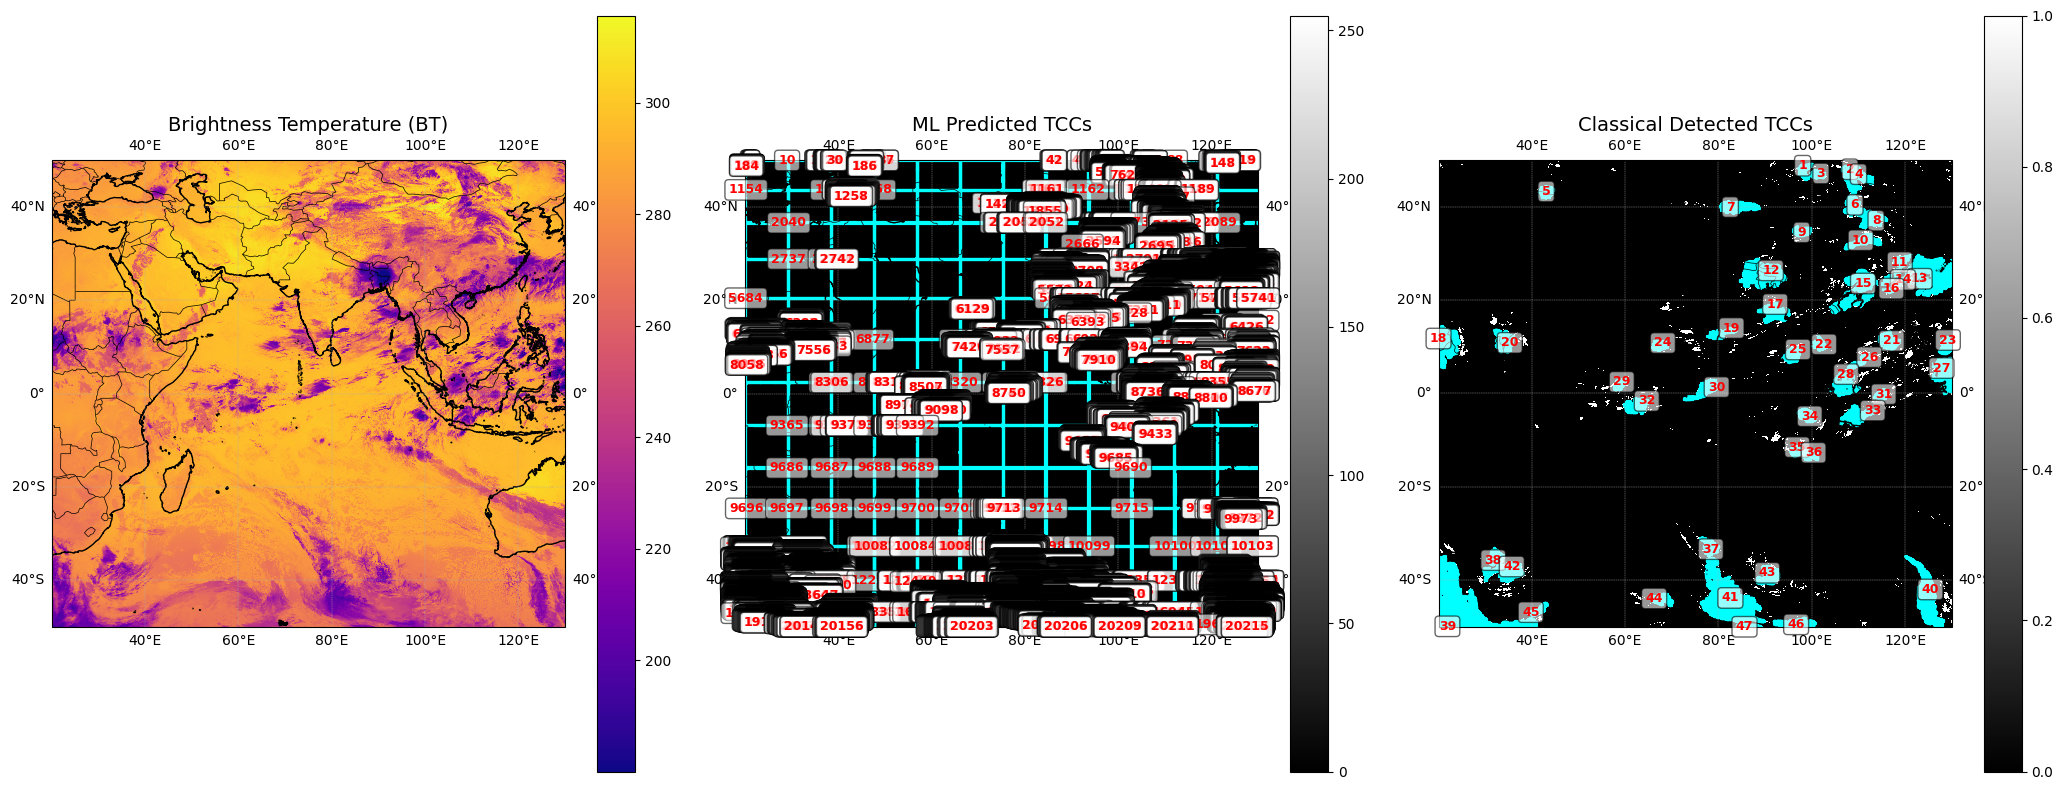

In [20]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from geopy.distance import geodesic
from scipy.ndimage import label
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === CONFIG ===
project_root = r'C:/Users/Rupam Manna/Desktop/INSAT_TCC_Project'
h5_file = os.path.join(project_root, 'raw_h5', '3DIMG_18JUN2024_0330_L1C_SGP_V01R00_B3.h5')
ml_mask_file = os.path.join(project_root, 'results', 'predictions', '3DIMG_18JUN2024_0330_L1C_SGP_V01R00_B3_ml_pred.npy')
bt_threshold = 235
min_area_km2 = 34800
min_deg_span = 1.0
indep_radius_km = 1200

# === LOAD DATA ===
with h5py.File(h5_file, 'r') as f:
    bt = f['/TIR1_BT'][0, :, :]
    x = f['/X'][:]
    y = f['/Y'][:]

# === LOAD PREDICTED MASK ===
predicted_mask = np.load(ml_mask_file)
binary_mask = (predicted_mask > 0.1).astype(np.uint8)

# === GEO PROJECTION ===
proj_merc = Proj(proj='merc', lon_0=75.0, lat_ts=0.0, a=6378137, b=6356752.3142)
X, Y = np.meshgrid(x, y)
lon, lat = proj_merc(X, Y, inverse=True)

# === MEMORY-EFFICIENT LABELING: CLASSICAL ===
mask_classical = bt < bt_threshold
labeled_classical, _ = label(mask_classical)

dx_m = np.mean(np.abs(np.diff(x)))
dy_m = np.mean(np.abs(np.diff(y)))
pixel_area_km2 = (dx_m / 1000) * (dy_m / 1000)

valid_classical_clusters = []
for cid in np.unique(labeled_classical)[1:]:
    y_idx, x_idx = np.where(labeled_classical == cid)
    if len(y_idx) == 0:
        continue

    area_km2 = len(y_idx) * pixel_area_km2
    lat_vals = lat[y_idx, x_idx]
    lon_vals = lon[y_idx, x_idx]

    if area_km2 < min_area_km2:
        continue
    if (lat_vals.max() - lat_vals.min() < min_deg_span) and (lon_vals.max() - lon_vals.min() < min_deg_span):
        continue

    bt_vals = bt[y_idx, x_idx]
    coldest_idx = np.argmin(bt_vals)
    cy, cx = y_idx[coldest_idx], x_idx[coldest_idx]

    valid_classical_clusters.append({
        'id': cid,
        'lat': lat[cy, cx],
        'lon': lon[cy, cx],
        'y_idx': y_idx,
        'x_idx': x_idx,
        'pixel_count': len(bt_vals)
    })

# === MEMORY-EFFICIENT LABELING: ML ===
labeled_ml, _ = label(binary_mask)

valid_ml_clusters = []
for cid in np.unique(labeled_ml)[1:]:
    y_idx, x_idx = np.where(labeled_ml == cid)
    if len(y_idx) == 0:
        continue

    bt_vals = bt[y_idx, x_idx]
    coldest_idx = np.argmin(bt_vals)
    cy, cx = y_idx[coldest_idx], x_idx[coldest_idx]

    valid_ml_clusters.append({
        'id': cid,
        'lat': lat[cy, cx],
        'lon': lon[cy, cx],
        'y_idx': y_idx,
        'x_idx': x_idx,
        'pixel_count': len(bt_vals)
    })

# === PLOT ALL THREE ===
fig, axes = plt.subplots(1, 3, figsize=(21, 8), subplot_kw={'projection': ccrs.PlateCarree()})
titles = ['Brightness Temperature (BT)', 'ML Predicted TCCs', 'Classical Detected TCCs']
colors = ['plasma', 'gray', 'gray']
data = [bt, binary_mask * 255, mask_classical.astype(int)]

for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=14)
    img = ax.pcolormesh(lon, lat, data[i], cmap=colors[i], shading='auto', transform=ccrs.PlateCarree())
    plt.colorbar(img, ax=ax, orientation='vertical')

    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

    clusters = [None, valid_ml_clusters, valid_classical_clusters]
    if clusters[i] is not None:
        for idx, cluster in enumerate(clusters[i], start=1):
            ax.scatter(lon[cluster['y_idx'], cluster['x_idx']],
                       lat[cluster['y_idx'], cluster['x_idx']],
                       s=1.5, color='cyan', transform=ccrs.PlateCarree())
            ax.text(cluster['lon'], cluster['lat'], str(idx), fontsize=9, color='red', weight='bold',
                    ha='center', va='center', transform=ccrs.PlateCarree(),
                    bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

    ax.set_extent([np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, linewidth=0.3, linestyle='--')

plt.tight_layout()
plt.show()